# Analysing the effectiveness of non-pharmaceutical interventions

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn import linear_model 

import datetime

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

### Some parameters have to be defined manually

In [2]:
# Define the time range which starts interval_start days before the death_limit and
# ends interval_end days after the death_limit
# The death limit will identify the date when at least death_limit people died in the country during one day

interval_start = 10
interval_end = 60
death_limit = 5

short_interval_end = 30  # This is defined to identify the traffic at the beginning of the epidemic

penalty = 4.5  # Penalty for the change point method

minimum_days_npi = 3   # NPI must last at least minimum_days_npi days this interval to be considered

# 'Czechia', and 'North Macedonia', 'Luxembourg', 'Slovakia', 'Latvia', dropped for now because 
# it would require more data cleaning than what is done so far

num_nordic_countries = 4 # How many countries at the beginning of the list are Nordic

european_countries = ['Sweden', 'Denmark', 'Finland', 'Norway', 
    'Germany', 'France', 'United Kingdom','Italy',
    'Spain', 'Ukraine', 'Poland', 'Romania',
    'Netherlands', 'Belgium', 'Greece', 'Portugal',
    'Hungary','Belarus', 'Austria', 'Switzerland',
    'Bulgaria', 'Serbia', 'Ireland', 'Croatia',
    'Bosnia and Herzegovina','Lithuania', 'Moldova', 'Slovenia',
    'Estonia']

In [3]:
# These directly follow from manual definitions 
num_countries = len(european_countries)
len_interval = interval_start + interval_end 

### There are three dataframes used in this notebook. The first one 'df_countries' holds general countrywise information, the second one 'dtypes_days' holds countrywise data which changes daily and the third one 'dtypes_npi_interval' holds information of countrywise NPI-intervals.

In [4]:
######################################
# Create a dataframe sorted by countries

dtypes_countries = np.dtype([
          ('country', str),
          ('aged_65_older', float),
          ('aged_70_older', float),
          ('gdp_per_capita', float),
          ('diabetes_prevalence', float),
          ('female_smokers', float),
          ('male_smokers', float),
          ('hospital_beds_per_thousand', float),
          ('means_traffic_beginning', float),
          ('means_traffic_end', float),
          ('total_deaths_per_million_last', float),
          ])
data_countries = np.empty(0, dtype=dtypes_countries)
df_countries = pd.DataFrame(data_countries)   


######################################
# Create a dataframe sorted by days

dtypes_days = np.dtype([
          ('country', str),
          ('date', np.datetime64),
          ('new_infections', int),
          ('new_deaths', int),
          ('total_deaths_per_million', float),
          ('total_traffic', float),
          ('npi_developments', float),
          ])
data_days = np.empty(0, dtype=dtypes_days)
df_days = pd.DataFrame(data_days)


######################################
# Create a dataframe sorted by NPI-intervals

dtypes_npi_interval = np.dtype([
          ('country', str),
          ('interval_start_date', np.datetime64),
          ('npi_interval_len', int),
          ('npi_increment', float),
          ('infected_coefficients', float),
          ('infected_intercepts', float),
          ('traffic_coefficients', float),
          ('traffic_intercepts', float),
          ])
data_npi_interval = np.empty(0, dtype=dtypes_npi_interval)
df_npi_interval = pd.DataFrame(data_npi_interval)   

### Let's download 'Our World in Data COVID-19'- dataset and add its data to dataframes 'df_countries' and 'df_days'

In [5]:
def load_covid_data():
    url = 'owid-covid-data.csv'
    data = pd.read_csv(url)
    return data

df_covid_data = load_covid_data()

In [6]:
for i in range(num_countries):
    current_country = european_countries[i]
    
    current_aged_65_older = df_covid_data.loc[(df_covid_data['location'] == current_country),
                            'aged_65_older'].values[0]
    
    current_aged_70_older = df_covid_data.loc[(df_covid_data['location'] == current_country),
                            'aged_70_older'].values[0]
    
    current_gdp_per_capita = df_covid_data.loc[(df_covid_data['location'] == current_country),
                            'gdp_per_capita'].values[0]
    
    current_diabetes_prevalence = df_covid_data.loc[(df_covid_data['location'] == current_country),
                            'diabetes_prevalence'].values[0]
    
    current_female_smokers = df_covid_data.loc[(df_covid_data['location'] == current_country),
                            'female_smokers'].values[0]
    
    current_male_smokers = df_covid_data.loc[(df_covid_data['location'] == current_country),
                            'male_smokers'].values[0]
    
    current_hospital_beds_per_thousand = df_covid_data.loc[(df_covid_data['location'] == current_country),
                            'hospital_beds_per_thousand'].values[0]
        
    new_data = {'country': [current_country], 'aged_65_older': [current_aged_65_older], 
                'aged_70_older': [current_aged_70_older], 'gdp_per_capita': [current_gdp_per_capita], 
                'diabetes_prevalence': [current_diabetes_prevalence], 'female_smokers': [current_female_smokers], 
                'male_smokers': [current_male_smokers], 'hospital_beds_per_thousand': [current_hospital_beds_per_thousand],
                'means_traffic_beginning': [0.0], 'means_traffic_end': [0.0], 
                'total_deaths_per_million_last': [0.0] } 
    
    df_extention = pd.DataFrame(new_data, index = [i])
    df_countries = pd.concat([df_countries, df_extention])

In [7]:
# Find the day of the death limit
date_death_limit = []

for current_country in european_countries:
    current_date_as_string = df_covid_data.loc[(df_covid_data['total_deaths'] >= death_limit) &
                  (df_covid_data['location'] == current_country), 'date'].values[0]
    
    date_death_limit.append(datetime.datetime.strptime(current_date_as_string, '%Y-%m-%d'))
 
    
date_end_point = []

for current_date in date_death_limit:
    date_end_point.append(current_date + datetime.timedelta(days=interval_end))


columns = ['country','date', 'new_infected', 'new_deaths', 'total_deaths_per_million']

for i in range(num_countries):
    current_country = european_countries[i]
    start_date = date_death_limit[i] - datetime.timedelta(days=interval_start) 
    end_date = date_death_limit[i] + datetime.timedelta(days=interval_end) 

    current_country_list = [current_country] * len_interval
    date_list = [start_date + datetime.timedelta(days=x) for x in range(len_interval)]

    new_infections = df_covid_data.loc[(df_covid_data['date'] >= start_date.strftime('%Y-%m-%d'))&
                  (df_covid_data['date'] < end_date.strftime('%Y-%m-%d'))&
                  (df_covid_data['location'] == current_country), 'new_cases'].tolist()

    new_deaths = df_covid_data.loc[(df_covid_data['date'] >= start_date.strftime('%Y-%m-%d'))&
                  (df_covid_data['date'] < end_date.strftime('%Y-%m-%d'))&
                  (df_covid_data['location'] == current_country), 'new_deaths'].tolist()

    total_deaths_per_million = df_covid_data.loc[
                  (df_covid_data['date'] >= start_date.strftime('%Y-%m-%d'))&
                  (df_covid_data['date'] < end_date.strftime('%Y-%m-%d'))&
                  (df_covid_data['location'] == current_country), 'total_deaths_per_million'].tolist()
    
    new_data = {'country':current_country_list, 'date': date_list, 'new_infections': new_infections,
                'new_deaths': new_deaths, 'total_deaths_per_million': total_deaths_per_million } 
    
    df_extention = pd.DataFrame(new_data)
    df_days = pd.concat([df_days, df_extention])

    # Update also the deaths to countrywise dataframe
    df_countries['total_deaths_per_million_last'][i] = total_deaths_per_million[-1]

/home/tommi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Let's download and clean Google's traffic data and add it to dataframe 'df_days'

In [8]:
def load_mobility_raw_onlynan():
    # url = 'https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv'
    url = 'Global_Mobility_Report.csv'
    data = pd.read_csv(url)
    data = data[data['sub_region_1'].isna()]
    data["date"] = pd.to_datetime(data["date"])
    
    data['retail_and_recreation_percent_change_from_baseline']=data.groupby('country_region_code')['retail_and_recreation_percent_change_from_baseline'].fillna(method='ffill')
    data['retail_and_recreation_percent_change_from_baseline']=data.groupby('country_region_code')['retail_and_recreation_percent_change_from_baseline'].fillna(method='bfill')
    data['grocery_and_pharmacy_percent_change_from_baseline']=data.groupby('country_region_code')['grocery_and_pharmacy_percent_change_from_baseline'].fillna(method='ffill')
    data['grocery_and_pharmacy_percent_change_from_baseline']=data.groupby('country_region_code')['grocery_and_pharmacy_percent_change_from_baseline'].fillna(method='bfill')
    data['parks_percent_change_from_baseline']=data.groupby('country_region_code')['parks_percent_change_from_baseline'].fillna(method='ffill')
    data['parks_percent_change_from_baseline']=data.groupby('country_region_code')['parks_percent_change_from_baseline'].fillna(method='bfill')
    data['transit_stations_percent_change_from_baseline']=data.groupby('country_region_code')['transit_stations_percent_change_from_baseline'].fillna(method='ffill')
    data['transit_stations_percent_change_from_baseline']=data.groupby('country_region_code')['transit_stations_percent_change_from_baseline'].fillna(method='bfill')
    data['workplaces_percent_change_from_baseline']=data.groupby('country_region_code')['workplaces_percent_change_from_baseline'].fillna(method='ffill')
    data['workplaces_percent_change_from_baseline']=data.groupby('country_region_code')['workplaces_percent_change_from_baseline'].fillna(method='bfill')
    data['residential_percent_change_from_baseline']=data.groupby('country_region_code')['residential_percent_change_from_baseline'].fillna(method='ffill')
    data['residential_percent_change_from_baseline']=data.groupby('country_region_code')['residential_percent_change_from_baseline'].fillna(method='bfill')

    data['workplaces_percent_change_from_baseline']=data.groupby('country_region_code')['workplaces_percent_change_from_baseline'].apply(lambda group: group.interpolate(method='index'))
    
    datav=data.values
    tot_mobility=list()
    for j in range(datav.shape[0]):
        temp=np.nanmean([datav[j,h] for h in range(7,13,1)])
        tot_mobility.append(temp)
        
    data=data.dropna(subset=['country_region'])

    data['Total Mobility']=tot_mobility
    data['Total Mobility']=data.groupby('country_region_code')['Total Mobility'].fillna(method='ffill')
    data['Total Mobility']=data.groupby('country_region_code')['Total Mobility'].fillna(method='bfill')
    data['Smooth Mobility']=data.groupby('country_region_code')['Total Mobility'].rolling(window = 7, win_type='boxcar').mean().reset_index(0,drop=True)
    data['Smooth Mobility']=data.groupby('country_region_code')['Smooth Mobility'].fillna(method='ffill')
    data['Smooth Mobility']=data.groupby('country_region_code')['Smooth Mobility'].fillna(method='bfill')
    data['Smooth Mobility']=data.groupby('country_region_code')['Smooth Mobility'].apply(lambda group: group.interpolate(method='index'))
    data=data.drop(columns=['sub_region_2','sub_region_1', 'iso_3166_2_code', 'census_fips_code'])
    
    return data

In [9]:
df0 = load_mobility_raw_onlynan()

total_traffic = []

for i in range(num_countries):
    current_country = european_countries[i]
    start_date = date_death_limit[i] - datetime.timedelta(days=interval_start)  
    end_date = start_date + datetime.timedelta(days=len_interval)
    
    new_total_traffic = df0.loc[(df0['date'] >= start_date.strftime('%Y-%m-%d'))&
                  (df0['date'] < end_date.strftime('%Y-%m-%d'))&
                  (df0['country_region'] == current_country), 'Total Mobility'].tolist()
    
    total_traffic = total_traffic + new_total_traffic
    
    means_traffic_beginning = sum(new_total_traffic[0:short_interval_end]) / short_interval_end
    means_traffic_end = sum(new_total_traffic[0:len_interval]) / len_interval
    
    df_countries.loc[df_countries.index == i, 'means_traffic_beginning'] = means_traffic_beginning
    df_countries.loc[df_countries.index == i, 'means_traffic_end'] = means_traffic_end
    
df_days['total_traffic'] = total_traffic

/home/tommi/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/home/tommi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice


### Let's download data from 'The Oxford COVID-19 Government Response Tracker (OxCGRT)' and add its data in the dataframe 'df_days' and 'df_npi_interval'

In [10]:
def load_npis():
    #url = 'https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv'
    url = 'covid-stringency-index.csv'
    data = pd.read_csv(url)
    
    data["Date"] = pd.to_datetime(data["Date"])
    return data

In [11]:
df_npis = load_npis()

npi_developments = []  # Multiple values possible for the same NPI inteval

infected_sorted_by_npi = [] # Infected grouped by NPI intervals
traffic_sorted_by_npi = []  # Traffic grouped by NPI intervals

changepoint_intervals = []  # Tells on which interval the changepoint belongs to

df0 = load_mobility_raw_onlynan() # Download the traffic data


for i in range(len(european_countries)):
    
    # Define the country inside the loop, also its time interval
    current_country = european_countries[i]
    interval_start_point = date_death_limit[i] - datetime.timedelta(days=interval_start)
    interval_end_point = date_death_limit[i] + datetime.timedelta(days=interval_end)

    # Define the npi-development and also same for the traffic
    current_npi_development = df_npis.loc[(df_npis['Entity'] == current_country) &
        (df_npis['Date'] >= interval_start_point) & (df_npis['Date'] < interval_end_point), 'GRSI'].tolist()
    
    current_traffic = df0[(df0['date'] >= interval_start_point) & (df0['date'] < interval_end_point)
              & (df0['country_region'] == current_country)]['Total Mobility'].tolist()
    
    current_new_infections = df_days[(df_days['country'] == current_country)]['new_infections'].tolist()
    
    # The development of NPIs can be added directly
    npi_developments = npi_developments + current_npi_development
    
    # Variables to help to update the dataframe df_npi_interval
    interval_start_date = interval_start_point      # This can be implemented better
    npi_increment = current_npi_development[0]    # This can be implemented better
    npi_interval_len_counter = 0
    npi_interval_index_counter = 0
    
    # Interval-lists will be added to current_infected_sorted and current_traffic_sorted!
    current_infected_sorted = []
    current_traffic_sorted = []
    current_infected_interval = []
    current_traffic_interval = []
    
    
    for j in range(len(current_npi_development) -1):
        npi_interval_len_counter += 1
        
        current_infected_interval.append(current_new_infections[j])
        current_traffic_interval.append(current_traffic[j])   
    
        # If NPIs are changed...
        if (current_npi_development[j] != current_npi_development[j+1]):
            
            # Concate a new row of the current country to the dataframe
            new_data = {'country': [current_country], 'interval_start_date': [interval_start_date],
                'npi_interval_len': [npi_interval_len_counter], 'npi_increment': [npi_increment]} 
            df_extention = pd.DataFrame(new_data, index = [npi_interval_index_counter])
            df_npi_interval = pd.concat([df_npi_interval, df_extention])

            # Update the variables
            interval_start_date = interval_start_point + datetime.timedelta(days=j+1)
            npi_increment = current_npi_development[j+1] - current_npi_development[j]
            npi_interval_len_counter = 0
            npi_interval_index_counter += 1    
            
            # As well the infected and the traffic sorted
            current_infected_sorted.append(current_infected_interval)
            current_infected_interval = []
            current_traffic_sorted.append(current_traffic_interval)
            current_traffic_interval = []
                
            # If the last two elements are different
            if j == len(current_npi_development) -2:
                
                # Update the current_infected_sorted and current_traffic_sorted
                current_infected_sorted.append([current_new_infections[j+1]])
                current_traffic_sorted.append([current_traffic[j+1]])
                
                # Concate a new row of the current country to the dataframe
                new_data = {'country': [current_country], 'interval_start_date': [interval_start_date],
                'npi_interval_len': [1], 'npi_increment': [npi_increment]} 
                df_extention = pd.DataFrame(new_data, index = [npi_interval_index_counter])
                df_npi_interval = pd.concat([df_npi_interval, df_extention])
        
        
        # If the last two elements are the same
        elif j == len(current_npi_development) -2:
            
            # Update the current_infected_sorted and current_traffic_sorted
            current_infected_interval.append(current_new_infections[j+1])
            current_traffic_interval.append(current_traffic[j+1])  
            current_infected_sorted.append(current_infected_interval)
            current_traffic_sorted.append(current_traffic_interval)
            
            # Concate a new row of the current country to the dataframe
            new_data = {'country': [current_country], 'interval_start_date': [interval_start_date],
            'npi_interval_len': [npi_interval_len_counter+1], 'npi_increment': [npi_increment]} 
            df_extention = pd.DataFrame(new_data, index = [npi_interval_index_counter])
            df_npi_interval = pd.concat([df_npi_interval, df_extention])

    infected_sorted_by_npi.append(current_infected_sorted)
    traffic_sorted_by_npi.append(current_traffic_sorted)
    
df_days['npi_developments'] = npi_developments

/home/tommi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice


In [12]:
infected_coefficients = []
infected_intercepts = []

traffic_coefficients = []
traffic_intercepts = []

for i in range(len(european_countries)):
    for j in range(len(infected_sorted_by_npi[i])):
        y_infected =  np.array(infected_sorted_by_npi[i][j])
        y_traffic =  np.array(traffic_sorted_by_npi[i][j])
        x = np.arange(len(y_infected)).reshape((-1, 1))
        
        if len(x) >= 2:
            regr = linear_model.LinearRegression()
            
            regr.fit(x, y_infected)
            infected_coefficients = infected_coefficients + [regr.coef_[0]]
            infected_intercepts = infected_intercepts + [regr.intercept_]
            
            regr.fit(x, y_traffic)
            traffic_coefficients = traffic_coefficients + [regr.coef_[0]]
            traffic_intercepts = traffic_intercepts + [regr.intercept_]
            
        # For one point, it is impossible to fit a line
        else:
            infected_coefficients = infected_coefficients + [-1000]
            infected_intercepts = infected_intercepts + [-1000]
            
            traffic_coefficients = traffic_coefficients + [-1000]
            traffic_intercepts = traffic_intercepts + [-1000]
            
df_npi_interval['infected_coefficients'] = infected_coefficients
df_npi_interval['infected_intercepts'] = infected_intercepts

df_npi_interval['traffic_coefficients'] = traffic_coefficients
df_npi_interval['traffic_intercepts'] = traffic_intercepts

### Implemented dataframes

In [13]:
# Dataframe sorted by countries 
df_countries 

,country,aged_65_older,aged_70_older,gdp_per_capita,diabetes_prevalence,female_smokers,male_smokers,hospital_beds_per_thousand,means_traffic_beginning,means_traffic_end,total_deaths_per_million_last
0,Sweden,19.985,13.433,46949.283,4.79,18.8,18.9,2.220,-6.044444,-3.340476,349.431
1,Denmark,19.677,12.325,46682.515,6.41,19.3,18.8,2.500,-10.050000,-4.335714,94.437
2,Finland,21.228,13.264,40585.721,5.76,18.3,22.6,3.280,-16.861111,-10.657143,55.588
3,Norway,16.821,10.813,64800.057,5.31,19.6,20.7,3.600,-16.472222,-10.014286,42.795
4,Germany,21.453,15.957,45229.245,8.31,28.2,33.1,8.000,-11.816667,-13.964286,88.525
5,France,19.718,13.079,38605.671,4.77,30.1,35.6,5.980,-16.544444,-36.216667,381.395
6,United Kingdom,18.517,12.527,39753.244,4.28,20.0,24.7,2.540,-11.705556,-26.797619,460.198
7,Italy,23.021,16.240,35220.084,4.78,19.8,27.8,3.180,-10.644444,-35.650000,422.564
8,Spain,19.436,13.799,34272.360,7.17,27.4,31.4,2.970,-21.972222,-41.435714,547.816
9,Ukraine,16.462,11.133,7894.393,7.11,13.5,47.4,8.800,-25.438889,-20.607143,14.108


In [14]:
# Dataframe sorted by days
df_days

,country,date,new_infections,new_deaths,total_deaths_per_million,total_traffic,npi_developments
0,Sweden,2020-03-07,76.0,0.0,0.000,8.500000,0.00
1,Sweden,2020-03-08,24.0,0.0,0.000,-1.166667,0.00
2,Sweden,2020-03-09,42.0,0.0,0.000,0.333333,11.11
3,Sweden,2020-03-10,45.0,0.0,0.000,-0.833333,11.11
4,Sweden,2020-03-11,78.0,0.0,0.000,0.666667,11.11
...,...,...,...,...,...,...,...
65,Estonia,2020-05-27,10.0,0.0,49.000,11.166667,50.00
66,Estonia,2020-05-28,6.0,1.0,49.754,3.000000,50.00
67,Estonia,2020-05-29,11.0,0.0,49.754,5.166667,50.00
68,Estonia,2020-05-30,8.0,1.0,50.507,7.833333,50.00


In [15]:
# Dataframe sorted by NPI intervals
df_npi_interval

,country,interval_start_date,npi_interval_len,npi_increment,infected_coefficients,infected_intercepts,traffic_coefficients,traffic_intercepts
0,Sweden,2020-03-07,2,0.00,-52.000000,76.000000,-9.666667,8.500000
1,Sweden,2020-03-09,3,11.11,18.000000,37.000000,0.166667,-0.111111
2,Sweden,2020-03-12,6,5.56,-11.171429,160.428571,-1.395238,-2.428571
3,Sweden,2020-03-18,1,3.70,-1000.000000,-1000.000000,-1000.000000,-1000.000000
4,Sweden,2020-03-19,6,8.33,-2.371429,147.428571,-0.880952,-5.325397
...,...,...,...,...,...,...,...,...
4,Estonia,2020-04-27,11,-2.78,-0.654545,10.363636,1.793939,-21.000000
5,Estonia,2020-05-08,3,-8.33,0.500000,6.166667,10.666667,-8.222222
6,Estonia,2020-05-11,4,-3.71,0.000000,4.500000,3.100000,-15.650000
7,Estonia,2020-05-15,3,-7.40,-1.500000,7.833333,0.166667,-10.055556


### Let's plot smoothened traffic data from some Nordic countries, Italy and Britain and compare it with one another

/home/tommi/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/home/tommi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice


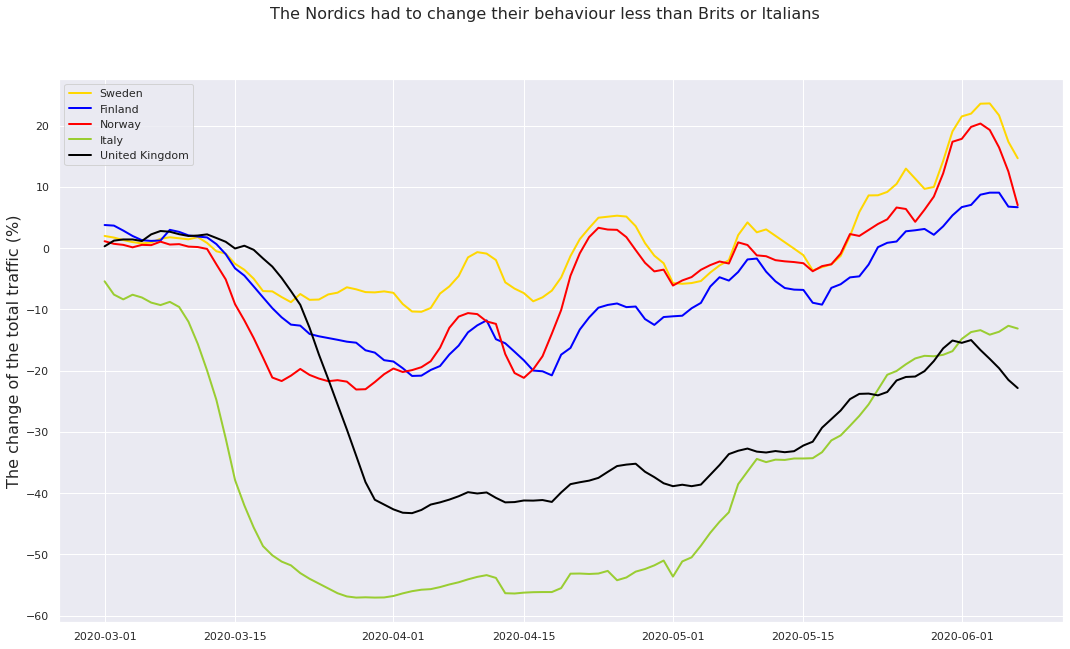

In [16]:
# REMARK: Smooth mobility is only used for this plot to make the graph clean

df1 = load_mobility_raw_onlynan()
plot_start_point = datetime.datetime.strptime('2020-03-01', '%Y-%m-%d')
df1 = df1[df1['date'] >= plot_start_point ]

fig = plt.figure(figsize=(18,10))

# Scandinavian countries
plt.plot( 'date', 'Smooth Mobility', data=df1.loc[(df1['country_region'] == 'Sweden')], 
        marker='', color='gold', linewidth=2, label="Sweden")
plt.plot( 'date', 'Smooth Mobility', data=df1.loc[(df1['country_region'] == 'Finland')],
         marker='', color='blue', linewidth=2, label="Finland")
plt.plot( 'date', 'Smooth Mobility', data=df1.loc[(df1['country_region'] == 'Norway')],
         marker='', color='red', linewidth=2, label="Norway")

# In comparision Austria, Italy
plt.plot( 'date', 'Smooth Mobility', data=df1.loc[(df1['country_region'] == 'Italy')],
         marker='', color='yellowgreen', linewidth=2, label="Italy")
plt.plot( 'date', 'Smooth Mobility', data=df1.loc[(df1['country_region'] == 'United Kingdom')],
         marker='', color='black', linewidth=2, label="United Kingdom")

plt.ylabel('The change of the total traffic (%)', fontsize=16)
fig.suptitle('The Nordics had to change their behaviour less than Brits or Italians', fontsize=16)
plt.legend(loc="upper left")

### The traffic was essential to get down in countries where COVID-19 escalated. However, there are countries who can deal with COVID-19 only getting the traffic down a little bit!

Text(0.5, 0, 'Average change in traffic, during 60 days after the first COVID-19 death (%)')

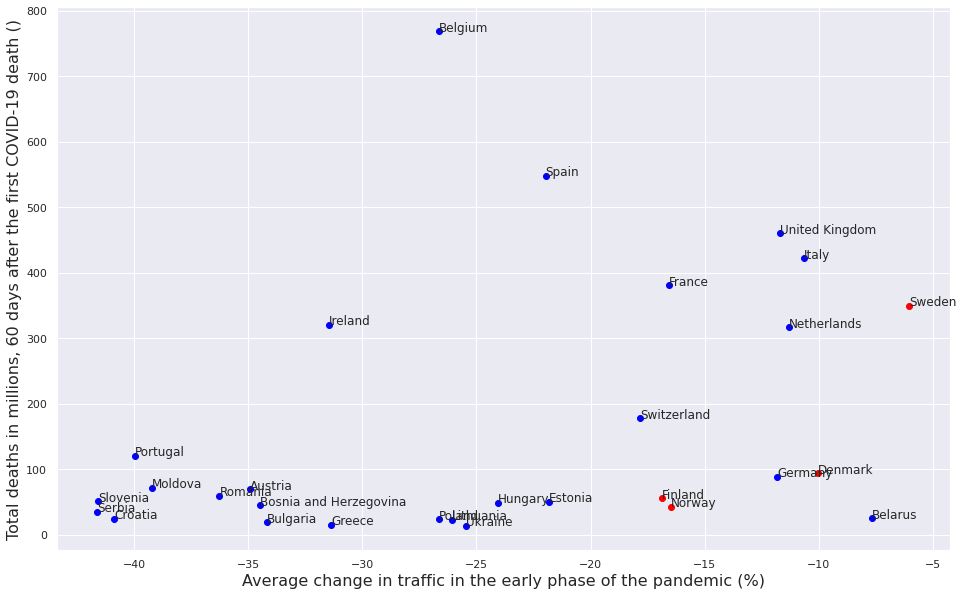

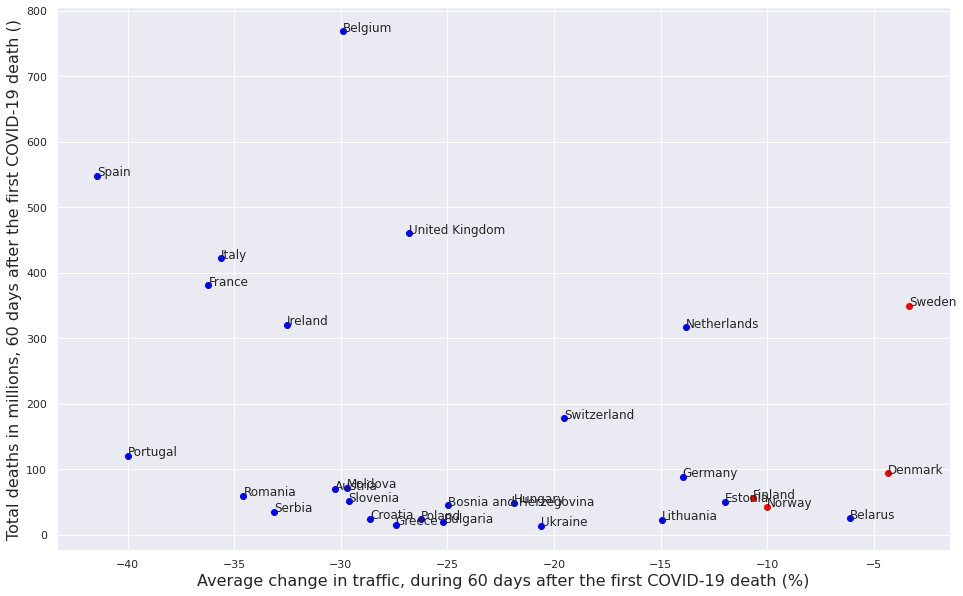

In [17]:
fig1, ax1 = plt.subplots(figsize=(16, 10))

ax1.scatter(df_countries['means_traffic_beginning'][0:num_nordic_countries], 
           df_countries['total_deaths_per_million_last'][0:num_nordic_countries], color='red')

ax1.scatter(df_countries['means_traffic_beginning'][num_nordic_countries:num_countries], 
           df_countries['total_deaths_per_million_last'][num_nordic_countries:num_countries], color='blue')

for i, txt in enumerate(european_countries):
    ax1.annotate(txt, (df_countries['means_traffic_beginning'][i],
                       df_countries['total_deaths_per_million_last'][i]))

plt.ylabel('Total deaths in millions, 60 days after the first COVID-19 death ()', fontsize=16)
# after 60 days at least 5 deaths is occured

plt.xlabel('Average change in traffic in the early phase of the pandemic (%)', fontsize=16)
# Time interval starts 10 days before 5 deaths is occured and continues 20 days


#####################################################################################

fig2, ax2 = plt.subplots(figsize=(16, 10))

ax2.scatter(df_countries['means_traffic_end'][0:num_nordic_countries], 
           df_countries['total_deaths_per_million_last'][0:num_nordic_countries], color='red')

ax2.scatter(df_countries['means_traffic_end'][num_nordic_countries:num_countries], 
           df_countries['total_deaths_per_million_last'][num_nordic_countries:num_countries], color='blue')

for i, txt in enumerate(european_countries):
    ax2.annotate(txt, (df_countries['means_traffic_end'][i],
                       df_countries['total_deaths_per_million_last'][i]))

plt.ylabel('Total deaths in millions, 60 days after the first COVID-19 death ()', fontsize=16)
# after 60 days at least 5 deaths is occured

plt.xlabel('Average change in traffic, during 60 days after the first COVID-19 death (%)', fontsize=16)
# Time interval starts 10 days before 5 deaths is occured and continues 60 days

### What do traffic and infected coefficients practically mean?

Example: Sweden

Sweden has 9 NPI-intervals. Each interval starts with a green line. Using linear regression,
for each interval there has been fitted a line.

NPI-interval number 1 has infected coefficient: -52.00 and traffic coefficient: -9.67
NPI-interval number 2 has infected coefficient: 18.00 and traffic coefficient: 0.17
NPI-interval number 3 has infected coefficient: -11.17 and traffic coefficient: -1.40
NPI-interval number 4 has only one point -> can't fit a line!
NPI-interval number 5 has infected coefficient: -2.37 and traffic coefficient: -0.88
NPI-interval number 6 has infected coefficient: 12.54 and traffic coefficient: -0.91
NPI-interval number 7 has infected coefficient: 56.00 and traffic coefficient: -2.42
NPI-interval number 8 has infected coefficient: 5.19 and traffic coefficient: 0.48
NPI-interval number 9 has infected coefficient: -3.03 and traffic coefficient: 0.10


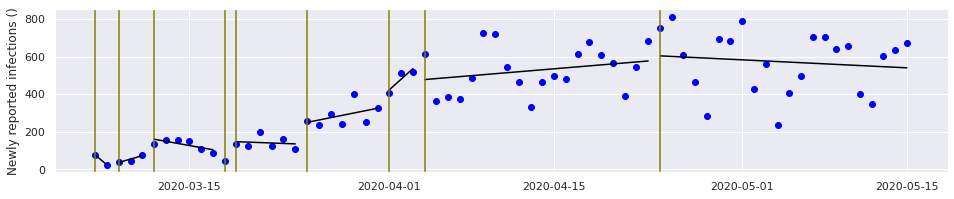

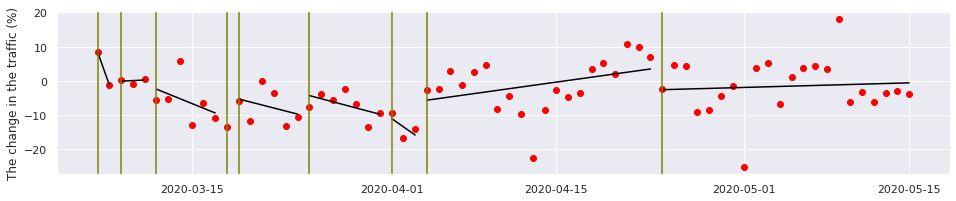

In [18]:
# Example Sweden

df_days_sweden = df_days[(df_days['country'] == 'Sweden')]
df_npi_interval_sweden = df_npi_interval[(df_npi_interval['country'] == 'Sweden')]


fig, ax = plt.subplots(figsize=(16, 3))
ax.scatter(df_days_sweden['date'], df_days_sweden['new_infections'], color='blue')

for i in range(len(df_npi_interval_sweden['interval_start_date'])):
    infected_coefficient = df_npi_interval_sweden['infected_coefficients'][i]
    infected_intercept = df_npi_interval_sweden['infected_intercepts'][i]
    
    interval_len = df_npi_interval_sweden['npi_interval_len'][i]
    t = range(interval_len)
    infected_fitted = np.multiply([infected_coefficient] * len(t), t) + np.array([infected_intercept] * len(t))

    date_interval = [df_npi_interval_sweden['interval_start_date'][i] + datetime.timedelta(days=x) for x in range(interval_len)]
    
    if interval_len >= 2:
        ax.plot(date_interval, infected_fitted, color='black')

plt.ylabel('Newly reported infections ()', fontsize=12)

for i in range(len(df_npi_interval_sweden['interval_start_date'])):
    plt.axvline(df_npi_interval_sweden['interval_start_date'][i], color='olive')

####################################################################################

fig2, ax2 = plt.subplots(figsize=(16, 3))
ax2.scatter(df_days_sweden['date'], df_days_sweden['total_traffic'], color='red')

for i in range(len(df_npi_interval_sweden['interval_start_date'])):
    traffic_coefficient = df_npi_interval_sweden['traffic_coefficients'][i]
    traffic_intercept = df_npi_interval_sweden['traffic_intercepts'][i]
    
    interval_len = df_npi_interval_sweden['npi_interval_len'][i]
    t = range(interval_len)
    traffic_fitted = np.multiply([traffic_coefficient] * len(t), t) + np.array([traffic_intercept] * len(t))

    date_interval = [df_npi_interval_sweden['interval_start_date'][i] + datetime.timedelta(days=x) for x in range(interval_len)]
    if interval_len >= 2:
        ax2.plot(date_interval, traffic_fitted, color='black')

plt.ylabel('The change in the traffic (%)', fontsize=12)

for i in range(len(df_npi_interval_sweden['interval_start_date'])):
    plt.axvline(df_npi_interval_sweden['interval_start_date'][i], color='olive')

print("Example: Sweden")
print()
print("Sweden has 9 NPI-intervals. Each interval starts with a green line. Using linear regression,")
print("for each interval there has been fitted a line.")
print()

for i in range(len(df_npi_interval_sweden['interval_start_date'])):
    interval_num = i + 1
    infected_coefficient = df_npi_interval_sweden['infected_coefficients'][i]
    traffic_coefficient = df_npi_interval_sweden['traffic_coefficients'][i]
    
    if infected_coefficient != -1000:
        print("NPI-interval number %d has infected coefficient: %.2f and traffic coefficient: %.2f" % (interval_num, infected_coefficient, traffic_coefficient))
    else:
        print("NPI-interval number %d has only one point -> can't fit a line!" %interval_num)

### Let's find correlations between the traffic and the infected coefficients

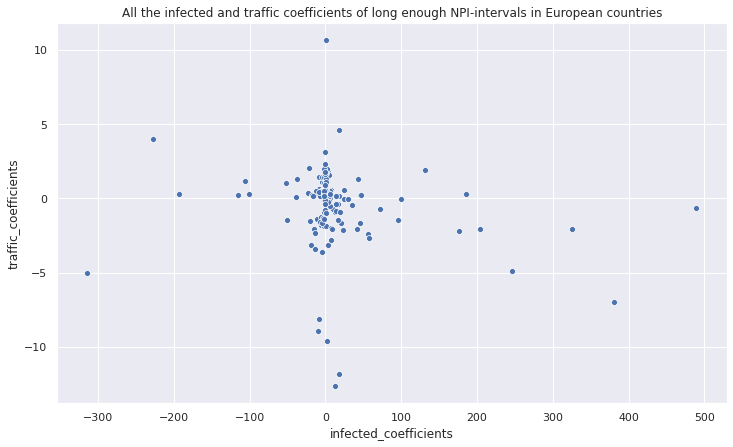

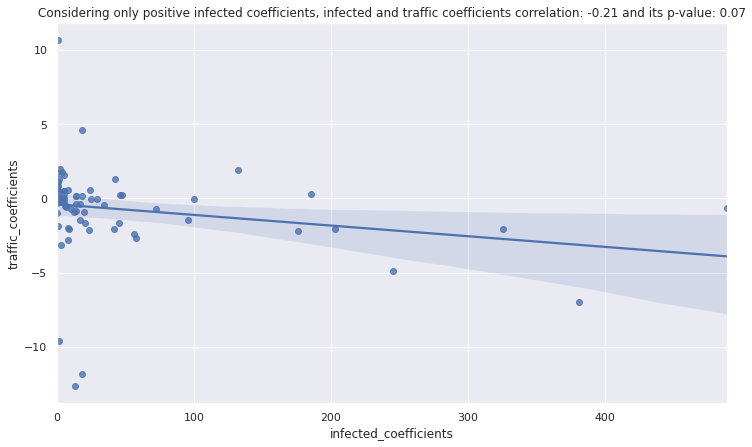

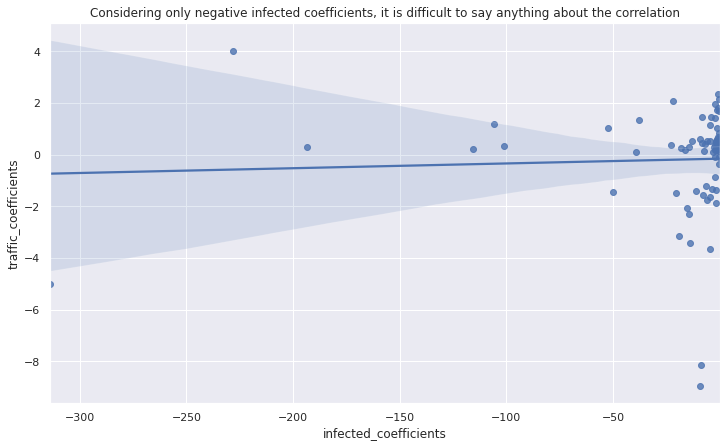

In [19]:
df_npi_interval_mod0 = df_npi_interval[(df_npi_interval['npi_interval_len'] >= 3)]

fig3, ax3 = plt.subplots(figsize=(12, 7))

ax3.set_title('All the infected and traffic coefficients of long enough NPI-intervals in European countries')

ax3 = sns.scatterplot(x="infected_coefficients", y="traffic_coefficients", #hue="npi_interval_len",
        data=df_npi_interval_mod0)
# potential hues and sizes: npi_increment, npi_interval_len

##################################################################################

df_npi_interval_mod1 = df_npi_interval[(df_npi_interval['npi_interval_len'] >= 3) &
                  (df_npi_interval['infected_coefficients'] > 0)]

fig4, ax4 = plt.subplots(figsize=(12, 7))

x = df_npi_interval_mod1['infected_coefficients']
y = df_npi_interval_mod1['traffic_coefficients']

slope, intercept, r, p, stderr = stats.linregress(x, y)  # r is pearson correlation
#print(stats.linregress(x, y))

ax4.set_title('Considering only positive infected coefficients, infected and traffic coefficients correlation: %.2f and its p-value: %.2f' % (r, p))

ax4 = sns.regplot(x="infected_coefficients", y="traffic_coefficients",
                     data=df_npi_interval_mod1)

##################################################################################

df_npi_interval_mod2 = df_npi_interval[(df_npi_interval['npi_interval_len'] >= 3) &
                  (df_npi_interval['infected_coefficients'] < 0)]

fig5, ax5 = plt.subplots(figsize=(12, 7))

x = df_npi_interval_mod2['infected_coefficients']
y = df_npi_interval_mod2['traffic_coefficients']

# slope, intercept, r, p, stderr = stats.linregress(x, y)  # r is pearson correlation
#print(stats.linregress(x, y))

ax5.set_title('Considering only negative infected coefficients, it is difficult to say anything about the correlation')


ax5 = sns.regplot(x="infected_coefficients", y="traffic_coefficients", 
                     data=df_npi_interval_mod2)